<h1 align='center' style='color:purple'>Credit Card Fraud - Imbalanced Data Set</h1>

**Use Case:** Credit Card Fraud Detection

    Compare different common algorithms, develop and optimize new 2 sequential/consecutive model algorithm to see if this can give better results
    
**Author:** Donald Stierman - Senior Data Scientist

**Details:** Imbalanced data can cause issues with most Machine Learning Algorithms and Neural Networks. To alleviate this, I choose to down-sample the training data to use as the input dataset. After creating the down-sampled dataset, I ran this several different common model algorithms, including a new modeling technique I developed specifically for imbalanced data. I got this idea after reading about some highly effective Healthcare screening solutions currently in use. I.E. Breast Cancer detection in women. If a mammogram comes back positive, we already know that there will be a lot of false positives (benign tumors, scars, etc). Usually the doctor will follow up with a 2nd test, such as biopsy. This will screen out the false positives leaving mostly true positives (cancerous tissue). This same idea can be applied to credit care fraud. We want to catch all true cases of fraud (fraud prevention), to be compliant with government regulations, and additionally not create a huge workload of false cases to be investigated (cost control).

**Here are some different ways to explain the methodology used in the Healthcare use case:**

*1st test (high specificity) -> 2nd test (high sensitivity) -> Only treat cancerous tissue

*TN/(TN + FP) is high ~ 1    -> TP/(TP + FN) is high ~ 1    -> Find all Positive cases

*catch all possible cases/remove healthy patients -> remove all false flags -> high confidence in Positive result/few missed positives


This same methodology can be applied to Credit Card Fraud detection

Link to code repo at Github:

https://github.com/donaldstierman/imbalanced_data

**Models used:**<pre>
    Logistic Regression
    Random Forest
    Gradient Boosted Decision Trees
    Customized 2 Step Gradient Boosted Decision Trees
    Deep Neural Network
    1D Convolutional Neural Network
    AutoEncoder
</pre>
**Goal:** 
For this example, I chose 2 metrics to optimize, AUC and best "macro avg recall". I chose these because in the health care example, it is better to catch all cancer patients, even if it means more tests are performed. To compare the results, first step is to find the best overall model (lowest mislabelled predictions), second is to find the model that has a low number of false negatives (faudulent transactions that are missed) without having too many false positives (genuine transactions that are needlessly investigated)
<pre>
    1) Compare the AUC to find the most robust model of the single step models. However, the value of this metric cannot be calculated on the 2 step model, so we need to use #2 below for final comparison
    2) Maximize the Sensitivity or reduce the number of False Negatives (FN/TP ratio) and maximize the Specificity to control the number of tests performed in the 2nd step. I.E. catch all the fraudulent transaction even if there are false flags (false positives).
</pre>
**Results:** The Customized 2 Step model has the best results overall. 
                          
                                AUC    Specificity/Sensitivity
                          
    Logistic Regression         .967    .95/.87
    Random Forest               .977    .97/.89  **best AUC**
    Gradient Boosted Tree       .976    .99/.84
    Customized 2 Step GB Trees  NA      .99/.93  **best overall**
    Deep Neural Network         .973    .95/.92  **2nd best overall**
    AutoEncoder                 .954    .88/.93    
    
    
Final Results: ROC Curve comparision


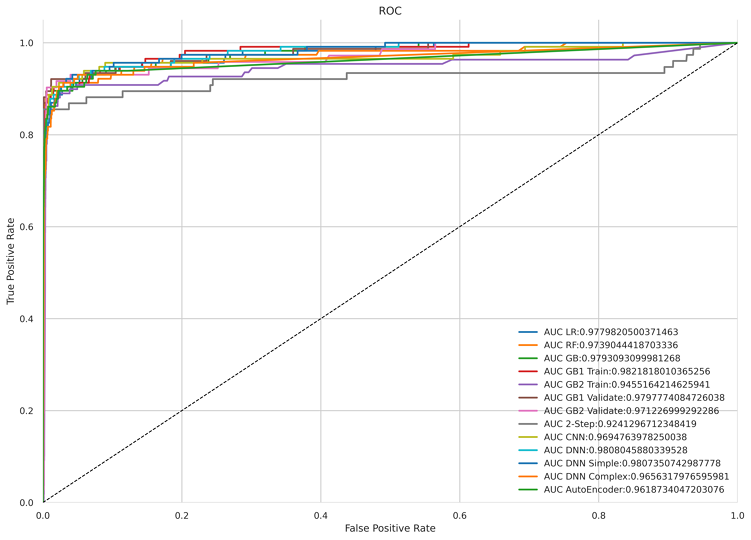

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import zipfile

import tensorflow as tf

In [2]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')
    #Path="drive/My Drive/Colab Notebooks/StockAnalysis"
    #Path=""
    #DataPath="/content"
    #RootPath="/root"    
else:
    #Path="/c/DataScience/Repo/Imbalanced_data"
    #Path="/DataScience/Repo/Imbalanced_data"
    #DataPath=Path
    #RootPath="/Users/iowahawk89"
    print("")

In [3]:
#with zipfile.ZipFile(DataPath+'/creditcard.zip', 'r') as zip_ref:
#    zip_ref.extractall(Path)

In [4]:
# Check if New path exists
if os.path.exists("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip")
elif os.path.exists("../input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("../input/creditcardzip")
else:
    print("Can't change the Current Working Directory") 
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\DataScience\Repo\Imbalanced_data\input\creditcardzip


In [5]:
# Load the Data Set
df = pd.read_csv('creditcard.csv')

Public Credit Card Dataset. This is financial data, and is considered to be sensitive so it is "encrypted" through the use of PCA to protect privacy. Only the Time and Dollar columns are intact after the "encryption"

In [6]:
# Check the data
print(df.head())

   Time_Series        V1        V2        V3        V4        V5        V6  \
0          0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1          0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount 

In [7]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time_Series  284807 non-null  float64
 1   V1           284807 non-null  float64
 2   V2           284807 non-null  float64
 3   V3           284807 non-null  float64
 4   V4           284807 non-null  float64
 5   V5           284807 non-null  float64
 6   V6           284807 non-null  float64
 7   V7           284807 non-null  float64
 8   V8           284807 non-null  float64
 9   V9           284807 non-null  float64
 10  V10          284807 non-null  float64
 11  V11          284807 non-null  float64
 12  V12          284807 non-null  float64
 13  V13          284807 non-null  float64
 14  V14          284807 non-null  float64
 15  V15          284807 non-null  float64
 16  V16          284807 non-null  float64
 17  V17          284807 non-null  float64
 18  V18          284807 non-

In [8]:
# Check the Uniqueness
df.nunique()

Time_Series    124592
V1             275663
V2             275662
V3             275663
V4             275662
V5             275662
V6             275662
V7             275662
V8             275661
V9             275662
V10            275659
V11            275662
V12            275662
V13            275663
V14            275662
V15            275661
V16            275661
V17            275662
V18            275662
V19            275661
V20            275661
V21            275660
V22            275661
V23            275659
V24            275662
V25            275661
V26            275661
V27            275659
V28            275653
Amount          32767
Class               2
dtype: int64

In [9]:
# Check for missing data
df.isnull().sum()

Time_Series    0
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount         0
Class          0
dtype: int64

In [10]:
# Check basic Statistics

df.describe(include ='all')

,Time_Series,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,-2.971792e-14,2.531226e-14,-1.923049e-14,1.093810e-14,-6.677660e-14,1.285053e-14,-5.204238e-14,1.023695e-14,2.237256e-15,...,-3.823399e-14,9.996013e-14,8.036320e-15,3.042869e-14,-8.644179e-14,-9.235807e-14,-5.269689e-14,9.542474e-14,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781942e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

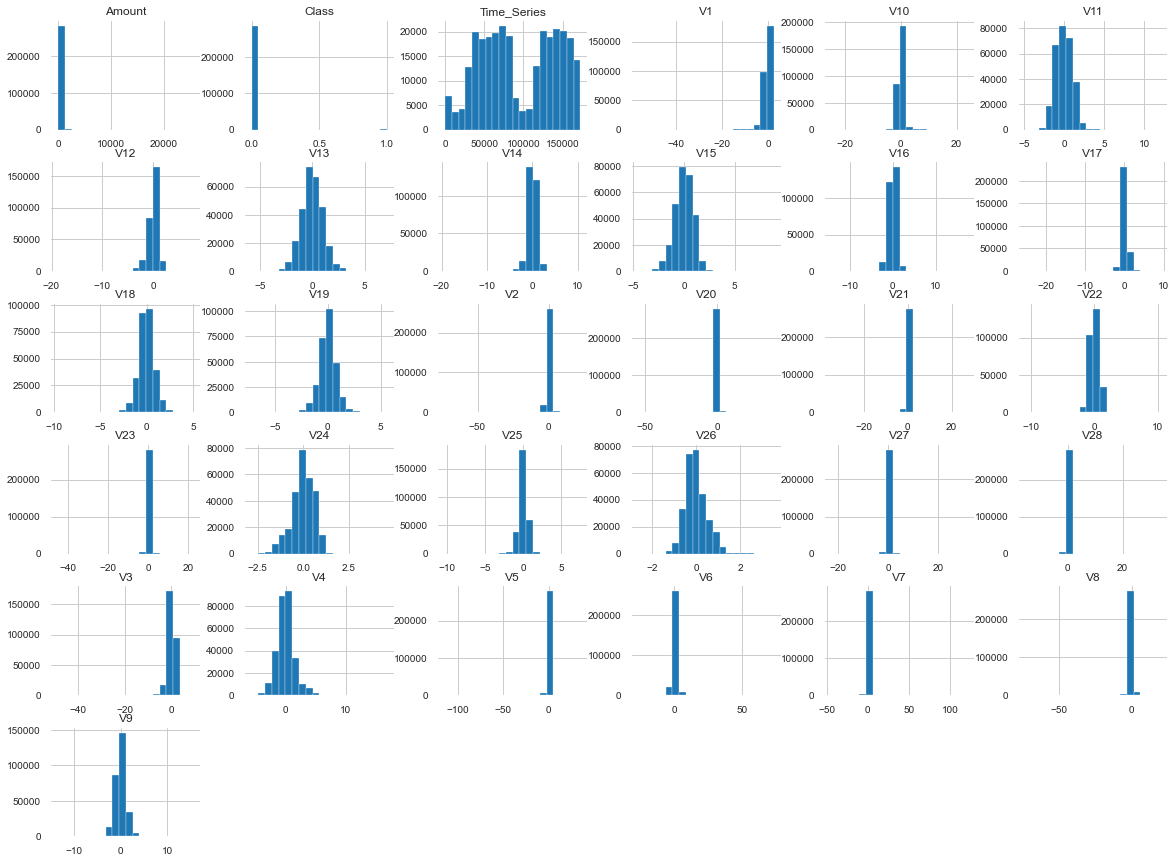

In [12]:
# Histograms of the features
# most of the data has a quasi-normal/gaussian distribution

df.hist(bins=20, figsize=(20,15))
plt.show()

Divide the dataset into features and labels and then into Train, Test and Validate datasets

In [13]:
# divide full data into features and label

X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
# Split the Data into Train and Test 

# create train, test and validate datasets

# first split original into Train and Test+Val
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = 0.4, random_state = 42)
# then split Test+Val into Test and Validate
# Validate will only be used in the 2 Model system (explained below)
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = 0.4, random_state = 42)

class_names=[0,1] # name  of classes 1=fraudulent transaction

In [14]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

In [15]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred, algo):
    model_probs = model_name.predict_proba(test_features)
    n = model_name.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error") 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    y=np.reshape(test_label.to_numpy(), -1)
    fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
    roc.append([algo, fpr, tpr, thresholds])
    # AUC score should be (Sensitivity+Specificity)/2
    print(algo + ':TEST | AUC Score: ' + str( round(metrics.auc(fpr, tpr),3 )))
    return tn, fp, fn, tp

In [17]:
def auc_roc_metrics(model, test_features, test_labels, algo): # model object, features, actual labels, name of algorithm
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only
    n = model.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]  
    model_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo) 
    return model_auc

In [18]:
def auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo):
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 3)

    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [19]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [20]:
def prediction_cutoff(model, test_features, cutoff):
    model.predict_proba(test_features)
    # to get the probability in each class, 
    # for example, first column is probability of y=0 and second column is probability of y=1.

    # the probability of being y=1
    prob1=model.predict_proba(test_features)[:,1]
    predicted=[1 if i > cutoff else 0 for i in prob1]
    return predicted

In [21]:
metrics_results = {}
roc = []

run Logistic Regression model first

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9563296417128729
0.9563296417128729
Accuracy score (training): 0.950
Accuracy score (validation): 0.956
error
Confusion Matrix:
false positive pct: 4.348016912205756
tn  fp  fn  tp
65262 2972 13 106
[[65262  2972]
 [   13   106]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     68234
           1       0.03      0.89      0.07       119

    accuracy                           0.96     68353
   macro avg       0.52      0.92      0.52     68353
weighted avg       1.00      0.96      0.98     68353

Specificity = 0.9564440015241669
Sensitivity = 0.8907563025210085
LR:TEST | AUC Score: 0.97


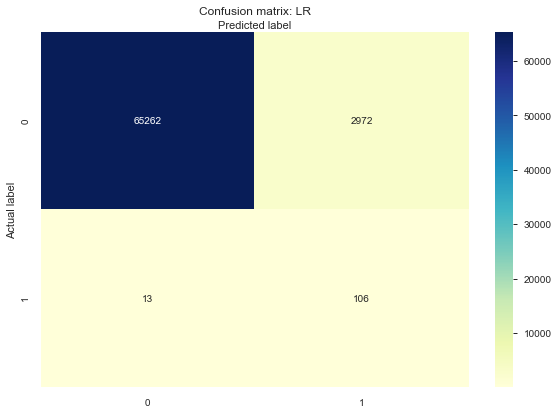

  No Skill : ROC AUC=0.500
        LR : ROC AUC=0.970


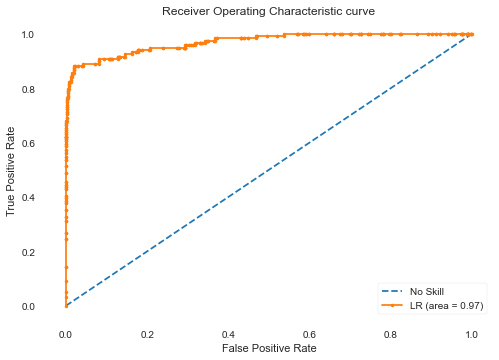

In [22]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
#lr_Pred = lr.predict(X_test)
# or
lr_Pred = prediction_cutoff(lr, X_test, 0.5) # 0.5 is the default cutoff for a logistic regression test

print(metrics.accuracy_score(y_test, lr_Pred))
tn, fp, fn, tp = display_metrics(lr, X_train, X_test, y_train, y_test, lr_Pred, 'LR')
visualize(y_test, lr_Pred, 'LR') # actual labels vs predicted labels
lr_auc = auc_roc_metrics(lr, X_test, y_test, 'LR')
metrics_results['lr'] = lr_auc


Logistic: f1=0.066 auc=0.463


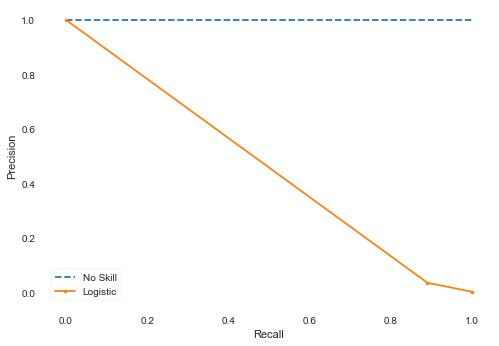

In [23]:
# useful for unbalanced data, maybe include later in metrics summary for all models

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_Pred)
lr_f1, lr_auc = f1_score(y_test, lr_Pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try the Random Forest model

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     68234
           1       0.05      0.89      0.09       119

    accuracy                           0.97     68353
   macro avg       0.52      0.93      0.53     68353
weighted avg       1.00      0.97      0.98     68353

0.9672728336722601
Accuracy score (training): 1.000
Accuracy score (validation): 0.967
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 3.2536977162670255
tn  fp  fn  tp
66010 2224 13 106
[[66010  2224]
 [   13   106]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     68234
           1       0.05      0.89      0.09       119

    accuracy                           0.97     68353
   macro avg       0.52      0.93      0.53     68353
weighted avg       1.00      0.97      0.98     68353

Specificity = 0.9674062783949351
Sensitivity = 0.8907563025210085
RF:TEST | AUC

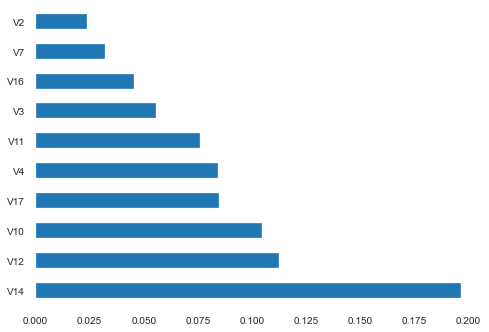

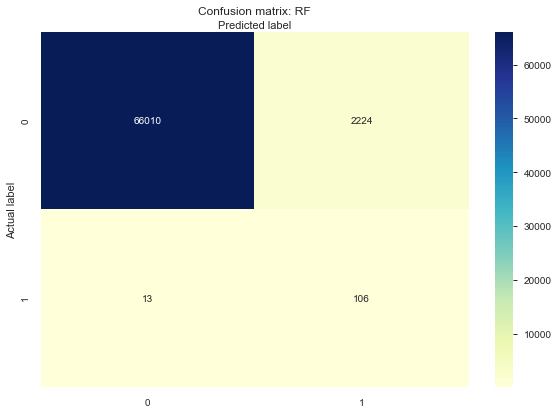

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.973


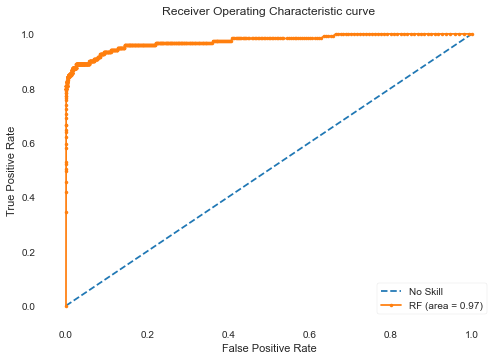

In [24]:
rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())

rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))
tn, fp, fn, tp = display_metrics(rf, X_train, X_test, y_train, y_test, rf_Pred, 'RF')
visualize(y_test, rf_Pred, 'RF')
rf_auc = auc_roc_metrics(rf, X_test, y_test, 'RF')
metrics_results['rf'] = rf_auc

So far, RandomForestClassifier has better prediction capability, the logistic regression test has a lot more mistakes in the False Positive category, and even a few more mistakes in the False Negative category.

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9787134434479833
Accuracy score (training): 0.945
Accuracy score (validation): 0.979
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.1052477579623425
tn  fp  fn  tp
66795 1439 16 103
[[66795  1439]
 [   16   103]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     68234
           1       0.07      0.87      0.12       119

    accuracy                           0.98     68353
   macro avg       0.53      0.92      0.56     68353
weighted avg       1.00      0.98      0.99     68353

Specificity = 0.9789108069290969
Sensitivity = 0.865546218487395
GB:TEST | AUC Score: 0.975


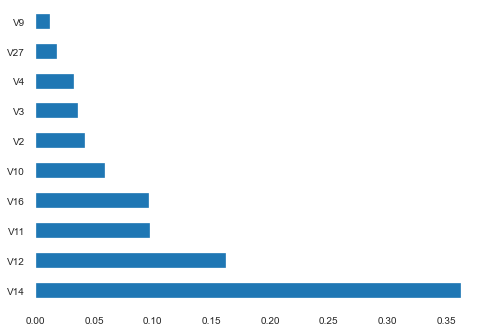

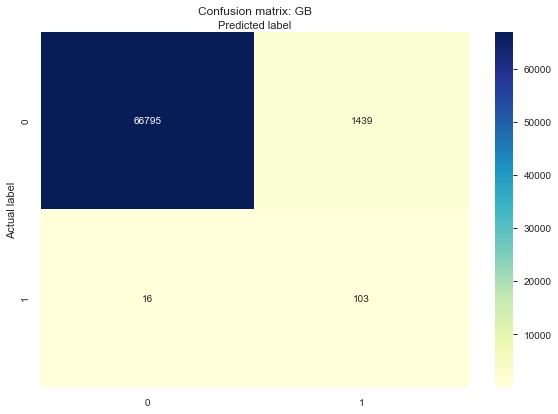

  No Skill : ROC AUC=0.500
        GB : ROC AUC=0.975


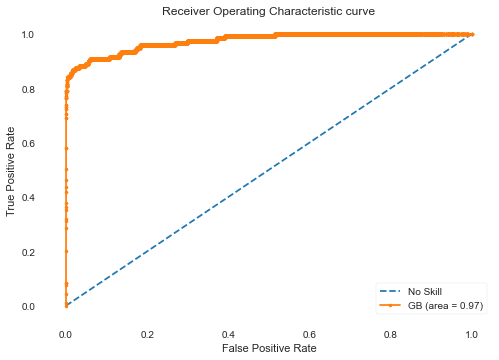

In [25]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0) ) #  fn = 12 and fp = 1057
# no weights gives worse false positive counts
#gb_clf.fit( X_train, y_train) # fn = 8 and fp = 2639

#use model to predict validation dataset
predictions = gb_clf.predict(X_test)

tn, fp, fn, tp = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions, 'GB')
visualize(y_test, predictions, 'GB')
gb_auc = auc_roc_metrics(gb_clf, X_test, y_test, 'GB')
metrics_results['gb'] = gb_auc

After tweaking the parameters, i can get a decent result from GradientBoostingClassifier. Changing the weights has a very large influence on the number of errors (FN and FP). Since this data is mostly 0 values, decreasing the weight of a true value vs a false value will decrease the FN, doing the opposite will decrease the FP. For one example run:  the sample_weight=np.where(y_train == 1,0.37,1.0) gives 13 FN and 795 FP. sample_weight=np.where(y_train == 1,0.1,1.0) gives 17 FN and 217 FP

My next idea is to run 2 consecutive models consecutively. 1st model should have low false negatives to catch (almost) all the actual positives, even if the number of false positives is high. Then only take these records with a predicted 1 value (should only be a few thousand), as the input for the next model. 2nd test should have low false positives to weed out the actual negatives. Will use the Validate dataset on the 2 models created from the Train and Test datasets

Current:
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M2(Filtered Test)
                Test
                
To Do:               
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M1 and M2(Validate)
                Test
                Validate

Can also try the inverse, but think that option will have less chance of success.

1st step

build the 1st model to be used later on the validate dataset

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8710224862112855
Accuracy score (training): 0.968
Accuracy score (validation): 0.871
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 12.883121443096865
tn  fp  fn  tp
59428 8806 10 109
[[59428  8806]
 [   10   109]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     68234
           1       0.01      0.92      0.02       119

    accuracy                           0.87     68353
   macro avg       0.51      0.89      0.48     68353
weighted avg       1.00      0.87      0.93     68353

Specificity = 0.8709441041123194
Sensitivity = 0.9159663865546218
GB1 Train:TEST | AUC Score: 0.971


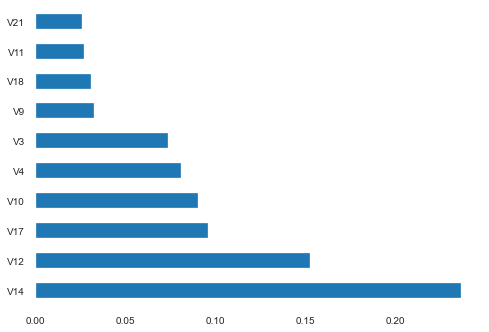

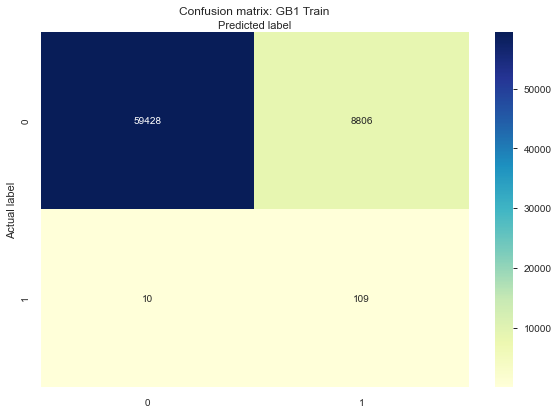

  No Skill : ROC AUC=0.500
 GB1 Train : ROC AUC=0.971


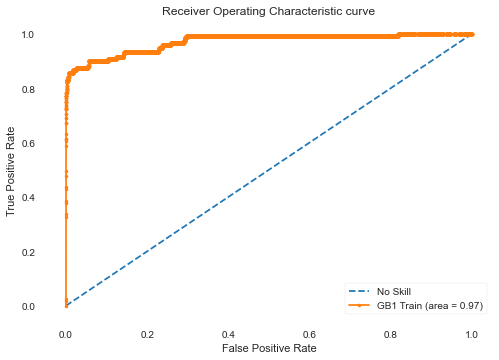

In [26]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf1.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf1.fit( X_train, y_train, sample_weight=np.where(y_train == 1,4.0,1.0) ) # was 5.0

#use model to predict validation dataset
predictions = gb_clf1.predict(X_test) 

tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_train, X_test, y_train, y_test, predictions, 'GB1 Train')
visualize(y_test, predictions, 'GB1 Train')
gb1_auc = auc_roc_metrics(gb_clf1, X_test, y_test, 'GB1 Train')
metrics_results['gb1_train'] = gb1_auc

2nd step takes all the Predicted Positives (the misclassified FP from upper right (~ 14000) plus the TP (since we won't use the actual value until the validation step)) and reprocesses these using a different model. The other 2 squares (Predicted 0's) are not included in the 2nd model, since we already have a low False negative result, so the initial predicted 0s don't change. Will need to add those back into the final results at the end.

Add 1st model prediction column to X_test for filtering

In [27]:
X_test['Prediction'] = predictions

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


select rows with prediction of 1

In [28]:
yes_ind = X_test[X_test['Prediction'] == 1].index

Create 2nd train dataset from 1st dataset where the prediction was 1

In [29]:
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]
X2_test = X2_test.drop(['Prediction'], axis=1)

In [30]:
# clean up the X_test dataset for future modeling, means remove the Prediction column
X_test = X_test.drop(['Prediction'], axis=1)

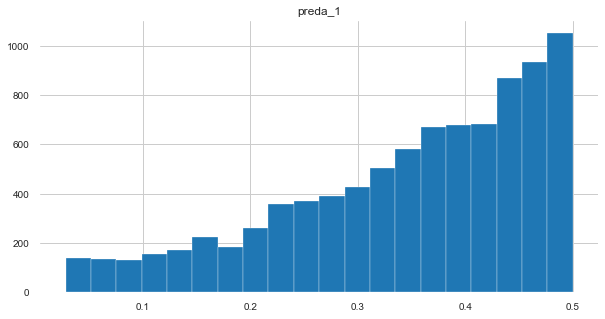

In [31]:
proba = gb_clf1.predict_proba(X2_test) 
pred = gb_clf1.predict(X2_test) 
df = pd.DataFrame(data=proba[:,0], columns=["preda_1"])
df.hist(bins=20, figsize=(10,5))
plt.show()

  No Skill : ROC AUC=0.500
      half : ROC AUC=0.966


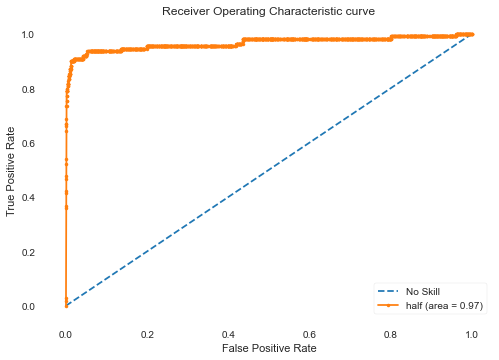

0.966

In [32]:
algo = 'half'
test_labels = y2_test
ns_probs = [0 for _ in range(len(test_labels))]
auc_roc_metrics_plots(proba[:,1], ns_probs, test_labels, algo)

build the 2nd model to be used model later on the validate dataset

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9236118900729108
Accuracy score (training): 0.929
Accuracy score (validation): 0.924
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 7.515423443634324
tn  fp  fn  tp
8136 670 11 98
[[8136  670]
 [  11   98]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      8806
           1       0.13      0.90      0.22       109

    accuracy                           0.92      8915
   macro avg       0.56      0.91      0.59      8915
weighted avg       0.99      0.92      0.95      8915

Specificity = 0.9239155121508063
Sensitivity = 0.8990825688073395
GB2 Train:TEST | AUC Score: 0.954


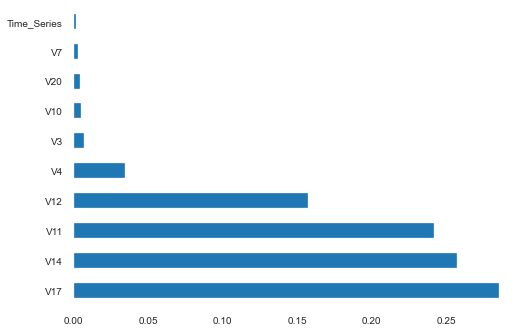

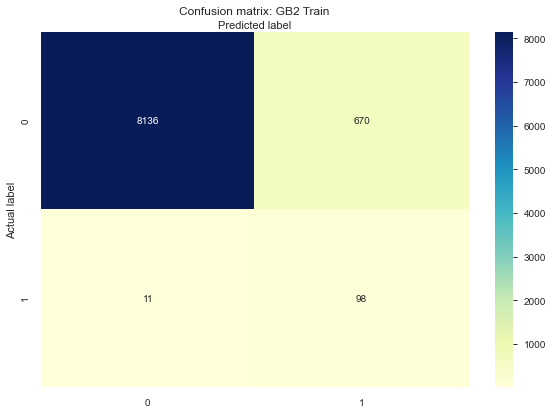

  No Skill : ROC AUC=0.500
 GB2 Train : ROC AUC=0.954


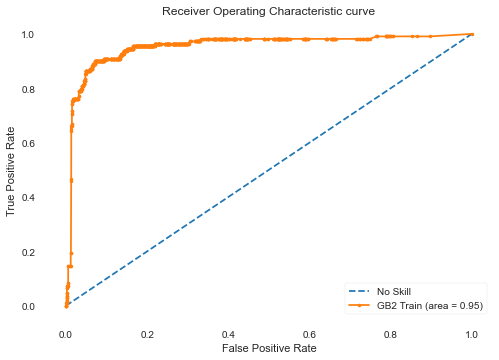

2 Step Final Confusion Matrix:
67564 670
21 98


Text(0.5, 352.48, 'Predicted label')

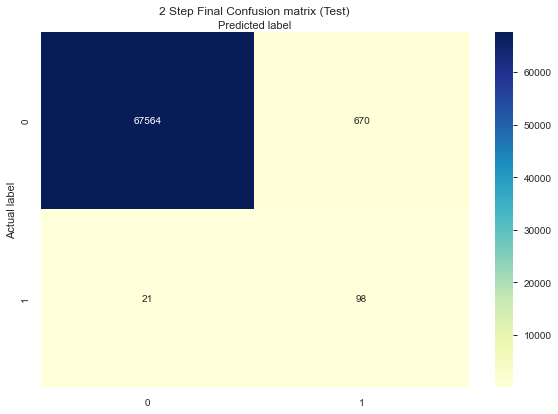

In [33]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=10, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf2.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf2.fit( X_train, y_train, sample_weight=np.where(y_train == 1,0.05,1.0) ) # was 0.1

#use model to predict validation dataset
predictions = gb_clf2.predict(X2_test) 

tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_test, y_train, y2_test, predictions, 'GB2 Train')

visualize(y2_test, predictions, 'GB2 Train')

gb2_auc = auc_roc_metrics(gb_clf2, X2_test, y2_test, 'GB2 Train')
metrics_results['gb2_train'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Test)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Now that we have built the 2 models from the test dataset, run the untouched validate dataset through both of them to get an unbiased result to compare against

In [34]:
# run the validate dataset through the first model
predictions1 = gb_clf1.predict(X_val)
predictions_proba1 = gb_clf1.predict_proba(X_val)
X1_val_final = X_val.copy()
X1_val_final=X1_val_final.join(y_val)
X1_val_final['Proba_1'] = predictions_proba1[:,1]
#X1_val_final
#X_val = X_val.sort_index(axis = 0) 

0.8737546631555848
Accuracy score (training): 0.871
Accuracy score (validation): 0.874
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 12.620144832126398
tn  fp  fn  tp
39747 5751 2 70
[[39747  5751]
 [    2    70]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     45498
           1       0.01      0.97      0.02        72

    accuracy                           0.87     45570
   macro avg       0.51      0.92      0.48     45570
weighted avg       1.00      0.87      0.93     45570

Specificity = 0.873598839509429
Sensitivity = 0.9722222222222222
GB1 Validate:TEST | AUC Score: 0.993


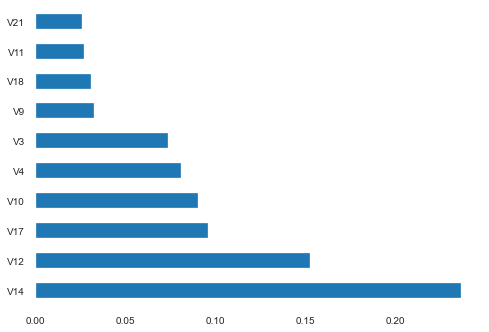

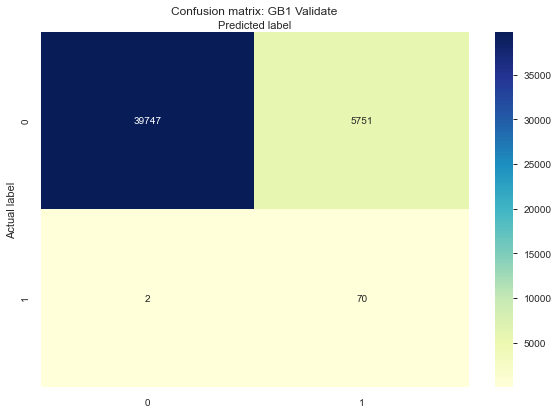

  No Skill : ROC AUC=0.500
GB1 Validate : ROC AUC=0.993


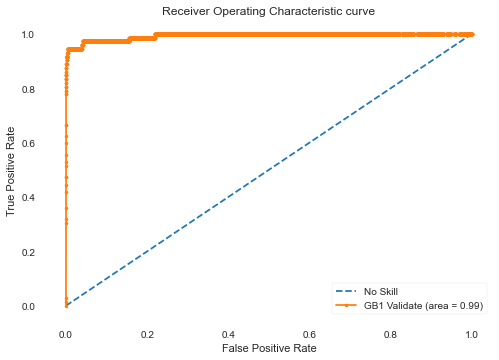

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [35]:
# adding this
# use both models to predict final validation dataset

tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_test, X_val, y_test, y_val, predictions1, 'GB1 Validate') 
visualize(y_val, predictions1, 'GB1 Validate')
gb1_auc = auc_roc_metrics(gb_clf1, X_val, y_val, 'GB1 Validate')
metrics_results['gb1_validate'] = gb1_auc

X_val['Prediction'] = predictions1

yes_ind = X_val[X_val['Prediction'] == 1].index

X2_val = X_val.loc[yes_ind]
y2_val = y_val.loc[yes_ind]
X2_val = X2_val.drop(['Prediction'], axis=1)
# run the validate dataset through the second model
predictions2 = gb_clf2.predict(X2_val)

X2_val_final = X2_val.copy()
X2_val_final.join(y2_val)
predictions_proba2 = gb_clf2.predict_proba(X2_val)
# validate the join!!
X2_val_final['Proba_2'] = predictions_proba2[:,1]
X2_val_final

cols_to_use = X2_val_final.columns.difference(X1_val_final.columns)
X_val_final = X1_val_final.join(X2_val_final[cols_to_use], how='left', lsuffix='_1', rsuffix='_2')
# rowwise action (axis=1)
X_val_final.loc[X_val_final['Proba_2'].isnull(),'Proba_2'] = X_val_final['Proba_1']
#X_val_final['Proba_2'].fillna(df['Proba_1'])
#X_val_final.query("Proba_1 != Proba_2")

0.9190860676859646
Accuracy score (training): 0.929
Accuracy score (validation): 0.919
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 8.039855694897783
tn  fp  fn  tp
5283 468 3 67
[[5283  468]
 [   3   67]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      5751
           1       0.13      0.96      0.22        70

    accuracy                           0.92      5821
   macro avg       0.56      0.94      0.59      5821
weighted avg       0.99      0.92      0.95      5821

Specificity = 0.918622848200313
Sensitivity = 0.9571428571428572
GB2 Validate:TEST | AUC Score: 0.962


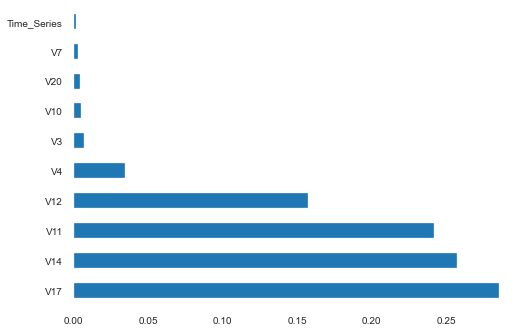

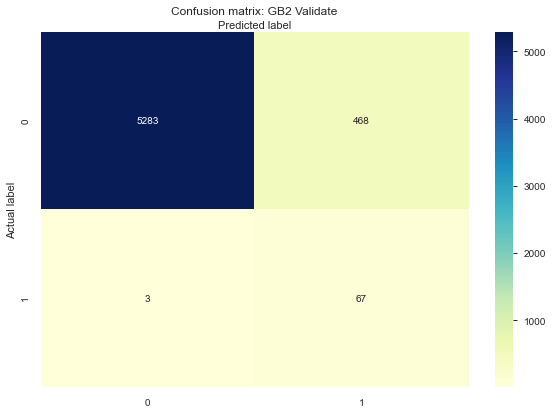

  No Skill : ROC AUC=0.500
GB2 Validate : ROC AUC=0.962


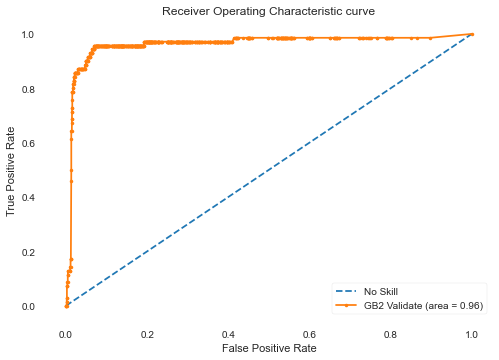

2 Step Final Confusion Matrix:
45030 468
5 67
Specificity = 0.9897138335751022
Sensitivity = 0.9305555555555556
2 Step Algorithm:TEST | AUC Score: 0.96


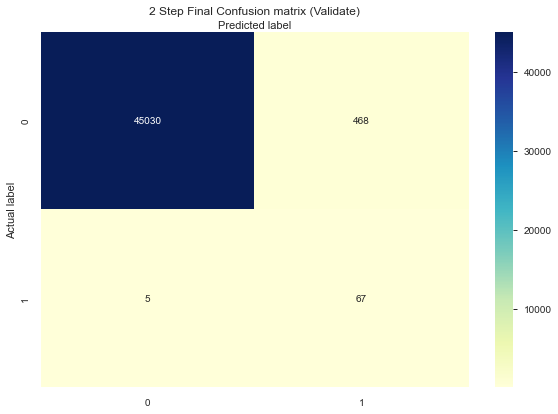

In [36]:
tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_val, y_train, y2_val, predictions2, 'GB2 Validate') 
visualize(y2_val, predictions2, 'GB2 Validate')
gb2_auc = auc_roc_metrics(gb_clf2, X2_val, y2_val, 'GB2 Validate')
metrics_results['gb2_validate'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Validate)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Specificity = (tn+tn1)/(tn+tn1+fp)
Sensitivity = tp/(tp+fn+fn1)

print("Specificity =", Specificity)
print("Sensitivity =", Sensitivity)

print('2 Step Algorithm' + ':TEST | AUC Score: ' + str( round( (Specificity+Sensitivity)/2,3 )))

# HERE
#two_step_auc = auc_roc_metrics(gb_clf, X_test, y_test, '2-Step')

  No Skill : ROC AUC=0.500
    2-Step : ROC AUC=0.957


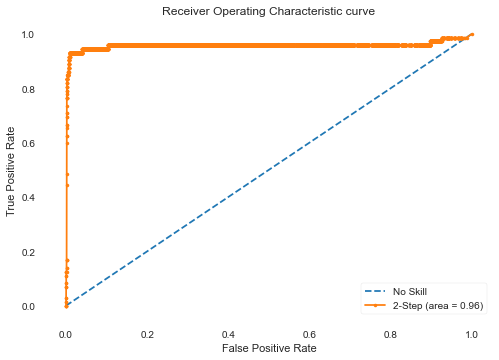

In [37]:
# try to combine the 2 models into one AUC score, however not sure that the proba values from 2 different models can be combined 
algo = '2-Step'
test_labels = X_val_final['Class']
ns_probs = [0 for _ in range(len(test_labels))]
model_probs = X_val_final['Proba_2']

two_step_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo)

metrics_results['2-step'] = two_step_auc

In [38]:
y=np.reshape(test_labels.to_numpy(), -1)
fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
roc.append([algo, fpr, tpr, thresholds])

The 2 step process has the highest sensitivity (and specificity) between the models. The 2 step process also improves the overall model prediction of positives by a large amount (FP/TP ratio from above 10x to below 2x). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 10x FP/TP ratio.

Next will try Neural Networks

In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

Using TensorFlow backend.


In [40]:
# create new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [41]:
# add this function to the list of Activation functions
get_custom_objects().update({'swish': Activation(swish)})

In [42]:
# prepare data for model
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
def create_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [44]:
def create_simple_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [45]:
def create_complex_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=20, kernel_initializer='uniform', activation='relu'),
        Dense(units=24, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [46]:
def create_cnn():
    model = Sequential()
    #model.add(Conv1D(32, 2, activation = 'relu', input_shape = input_shape))
    #model.add(Conv1D(filters=32, kernel_size=2, input_shape = (30) ))
    #model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='swish', padding='valid', input_shape=input_shape ))
    model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='relu', padding='valid', input_shape=input_shape ))
    # TypeError: 'int' object is not iterable
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 32)            352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 64)             256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)            

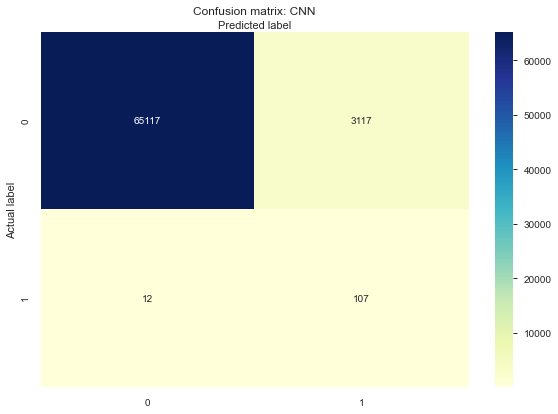

  No Skill : ROC AUC=0.500
       CNN : ROC AUC=0.975


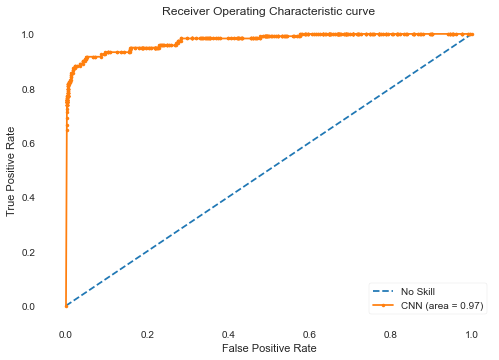

In [47]:
input_shape = (X_train.shape[1], 1)
clf = create_cnn()
# NameError: name 'input_shape' is not defined

# reshape data for CNN expected input
nrows, ncols = X_train.shape # (602,30)
X_train_arr = X_train.copy()
y_train_arr = y_train.copy()
X_train_arr = X_train_arr.reshape(nrows, ncols, 1)

nrows, ncols = X_test.shape # (602,30)
X_test_arr = X_test.copy()
y_test_arr = y_test.copy()
X_test_arr = X_test_arr.reshape(nrows, ncols, 1)

#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# Let's train the model using RMSprop
#clf.compile(loss='binary_crossentropy',
#              optimizer=opt,
#              metrics=['accuracy'])
# or
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

clf.summary()

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=16, epochs=20, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
# or
clf.fit(X_train_arr, y_train_arr, epochs=200, verbose=1, sample_weight=np.where(y_train_arr == 1,1.0,1.0).flatten())
# check model metrics
score = clf.evaluate(X_train_arr, y_train_arr, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test_arr, y_test_arr, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test_arr, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test_arr, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (CNN)") 
print(classification_report(y_test_arr, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train_arr, X_test_arr, y_train_arr, y_test_arr, yhat_classes, 'CNN')
visualize(y_test_arr, yhat_classes, 'CNN')
cnn_auc = auc_roc_metrics(clf, X_test_arr, y_test_arr, 'CNN')
metrics_results['cnn'] = cnn_auc

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_4 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
____________________________________________________

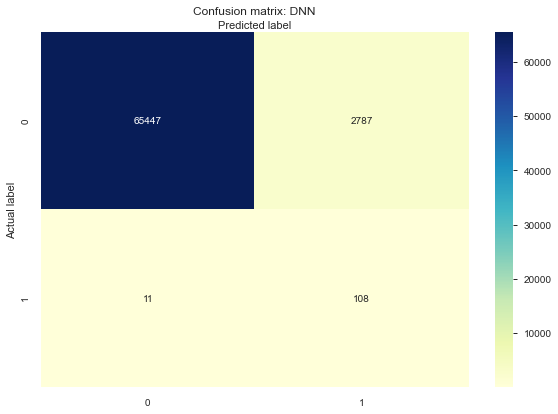

  No Skill : ROC AUC=0.500
       DNN : ROC AUC=0.977


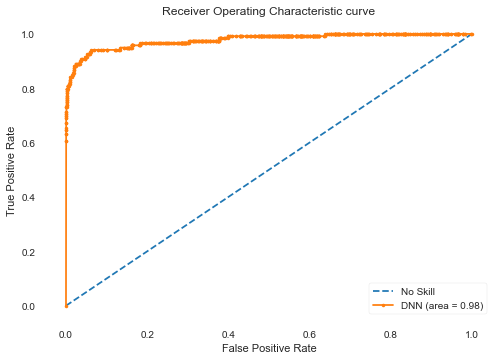

In [48]:
clf = create_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=20, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN')
visualize(y_test, yhat_classes, 'DNN')
dnn_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN')
metrics_results['dnn'] = dnn_auc

Results from Deep NN are better than 1 step/model examples, but overall not quite as good as the 2 step/model process. I can get the sensitivity to be as good, but in that case, the specificity is much lower. As more data is added or processed through this DNN, the results should improve, maybe eventually beating the 2 step model. However, it seems that increasing the number of epochs will weight the model to higher false negatives, similar to using sample weights for the GBM model:

**sample_weight=np.where(y_train == 1,0.1,1.0)**

**giving a 1 in the training data 10 times the weight or inflence of a 0**

For now, we will keep the number of epochs at 5.
Weighting has the same effect on this DNN as it had on the GBM. Best all around result with 

sample_weight=np.where(y_train == 1,0.1,1.0).flatten()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_9 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 19        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
602/602 [==============================] - 0s 342us/step - loss: 1.7176 - accuracy: 0.5116
Epoch 2/32
602/602 [==============================] - 0s 50us/step - loss: 1.6365 - accuracy: 0.5000
Epoch 3/32
602/602 [==============================] - 0s 50us/step - loss: 1.4160 - accuracy: 0.5000
Epoch 4/32
602/602 [==============================] - 0s 54us/step - loss: 1.1186 

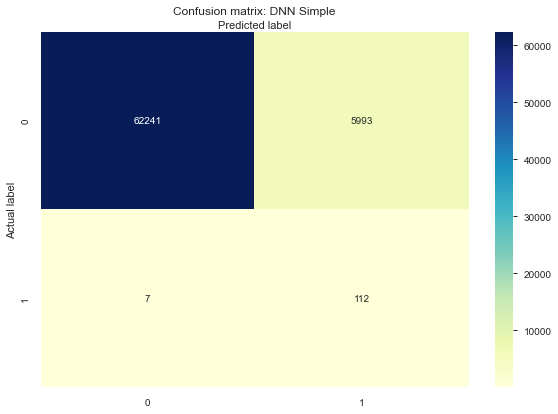

  No Skill : ROC AUC=0.500
DNN-Simple : ROC AUC=0.979


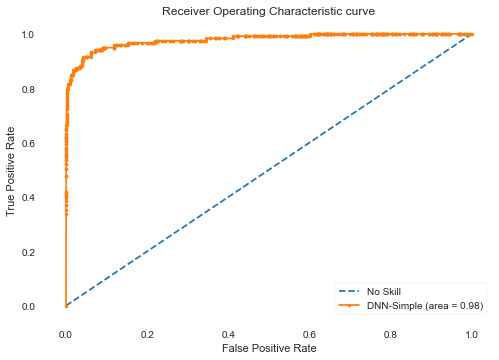

In [49]:
clf = create_simple_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN Simple)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Simple')
visualize(y_test, yhat_classes, 'DNN Simple')
dnn_simple_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Simple')
metrics_results['dnn_simple'] = dnn_simple_auc

This DNN is successful at reducing the FP/TP ratio. This is expected as a Neural Network can decide on its own rules to include based on the input data. Below I try other more and less complex methods, but so far the results are not as good.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_12 (Dense)             (None, 18)                306       
_________________________________________________________________
dropout_5 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                570       
_________________________________________________________________
dense_14 (Dense)             (None, 28)                868       
_________________________________________________________________
dropout_6 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)               

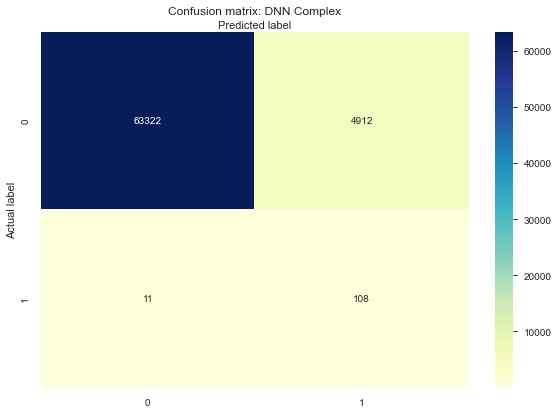

  No Skill : ROC AUC=0.500
DNN-Complex : ROC AUC=0.944


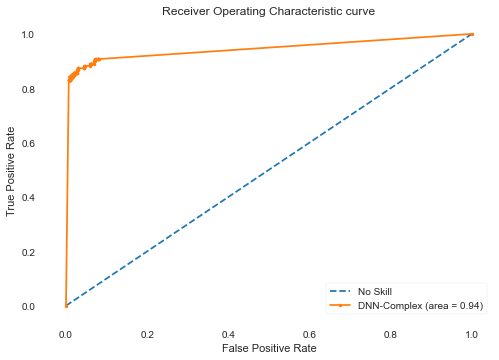

In [50]:
clf = create_complex_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN complex)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Complex')
visualize(y_test, yhat_classes, 'DNN Complex')
dnn_complex_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Complex')
metrics_results['dnn_complex'] = dnn_complex_auc

In [51]:
def create_autoencoder():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=15, kernel_initializer='uniform', input_dim=30, activation='tanh', activity_regularizer=regularizers.l1(10e-5)),
        Dense(units=7, kernel_initializer='uniform', activation='relu'),
        Dense(units=7, kernel_initializer='uniform', activation='tanh'),
        Dense(units=31, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_23 (Dense)             (None, 31)                248       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 32        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
602/602 [==============================] - 1s 1ms/step - loss: 3.0649 - accuracy: 0.4983
Epoch 2/32
602/602 [==

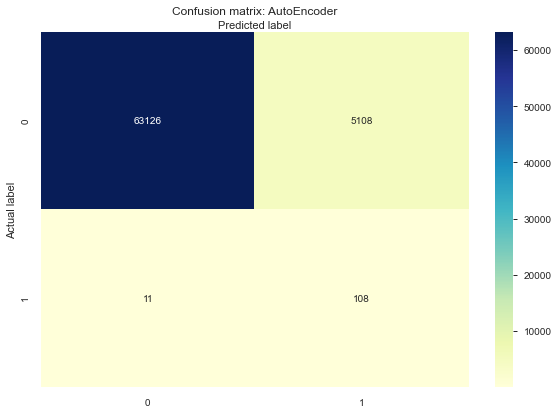

  No Skill : ROC AUC=0.500
AutoEncoder : ROC AUC=0.961


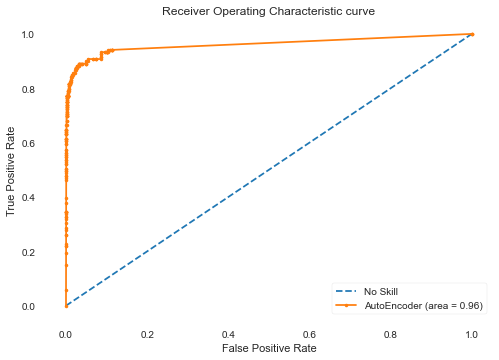

In [52]:
clf = create_autoencoder()
clf.summary()
#clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=32, epochs=32, shuffle=True)#, validation_data=(X_test, X_test))
clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,8.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=32)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=32)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (AutoEncoder)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'AutoEncoder')
visualize(y_test, yhat_classes, 'AutoEncoder')
autoencoder_auc = auc_roc_metrics(clf, X_test, y_test, 'AutoEncoder')
metrics_results['autoencoder'] = autoencoder_auc

In [53]:
print("AUC comparisons")
print(metrics_results)

AUC comparisons
{'lr': 0.97, 'rf': 0.973, 'gb': 0.975, 'gb1_train': 0.971, 'gb2_train': 0.954, 'gb1_validate': 0.993, 'gb2_validate': 0.962, '2-step': 0.957, 'cnn': 0.975, 'dnn': 0.977, 'dnn_simple': 0.979, 'dnn_complex': 0.944, 'autoencoder': 0.961}


<pre>
AUC comparisons

{'lr': 0.965, 'rf': 0.975, 'gb': 0.975, 'gb1_train': 0.979, 'gb2_train': 0.967, 'gb1_validate': 0.99, 'gb2_validate': 0.974, '2-step': 0.941, 'dnn': 0.964, 'dnn_simple': 0.978, 'dnn_complex': 0.939, 'autoencoder': 0.956}
{'lr': 0.968, 'rf': 0.979, 'gb': 0.976, 'gb1_train': 0.975, 'gb2_train': 0.968, 'gb1_validate': 0.991, 'gb2_validate': 0.978, '2-step': 0.957, 'dnn': 0.983, 'dnn_simple': 0.981, 'dnn_complex': 0.961, 'autoencoder': 0.952}

Side by Side comparisions of all models


    LR
    [[64954  3280]
     [   15   104]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.87      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.91      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    RF
    [[66254  1980]
     [   13   106]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.97      0.99     68234
               1       0.05      0.89      0.10       119

        accuracy                           0.97     68353
       macro avg       0.53      0.93      0.54     68353
    weighted avg       1.00      0.97      0.98     68353


    GB
    [[66732  1502]
     [   16   103]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.98      0.99     68234
               1       0.06      0.87      0.12       119

        accuracy                           0.98     68353
       macro avg       0.53      0.92      0.55     68353
    weighted avg       1.00      0.98      0.99     68353


    2Step
    [[45336  162]
     [   5    67]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.99      0.99     45377
               1       0.36      0.93      0.52        72
        accuracy                           0.??     45449
       macro avg       0.57      0.96      0.71     45449
    weighted avg       1.00      0.99      0.99     45449


    DNN
    [[64991  3243]
     [    9   110]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.92      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.94      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    DNN Simple
    [[63011  5223]
     [    6   113]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.92      0.96     68234
               1       0.02      0.95      0.04       119

        accuracy                           0.92     68353
       macro avg       0.51      0.94      0.50     68353
    weighted avg       1.00      0.92      0.96     68353


    AutoEncoder
    60277 7957 7 112
    [[60277  7957]
     [    7   112]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.88      0.94     68234
               1       0.01      0.94      0.03       119

        accuracy                           0.88     68353
       macro avg       0.51      0.91      0.48     68353
    weighted avg       1.00      0.88      0.94     68353
    
    
    CNN
    [[64761  3473]
     [   14   105]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.97     68234
               1       0.03      0.88      0.06       119

        accuracy                           0.95     68353
       macro avg       0.51      0.92      0.52     68353
    weighted avg       1.00      0.95      0.97     68353




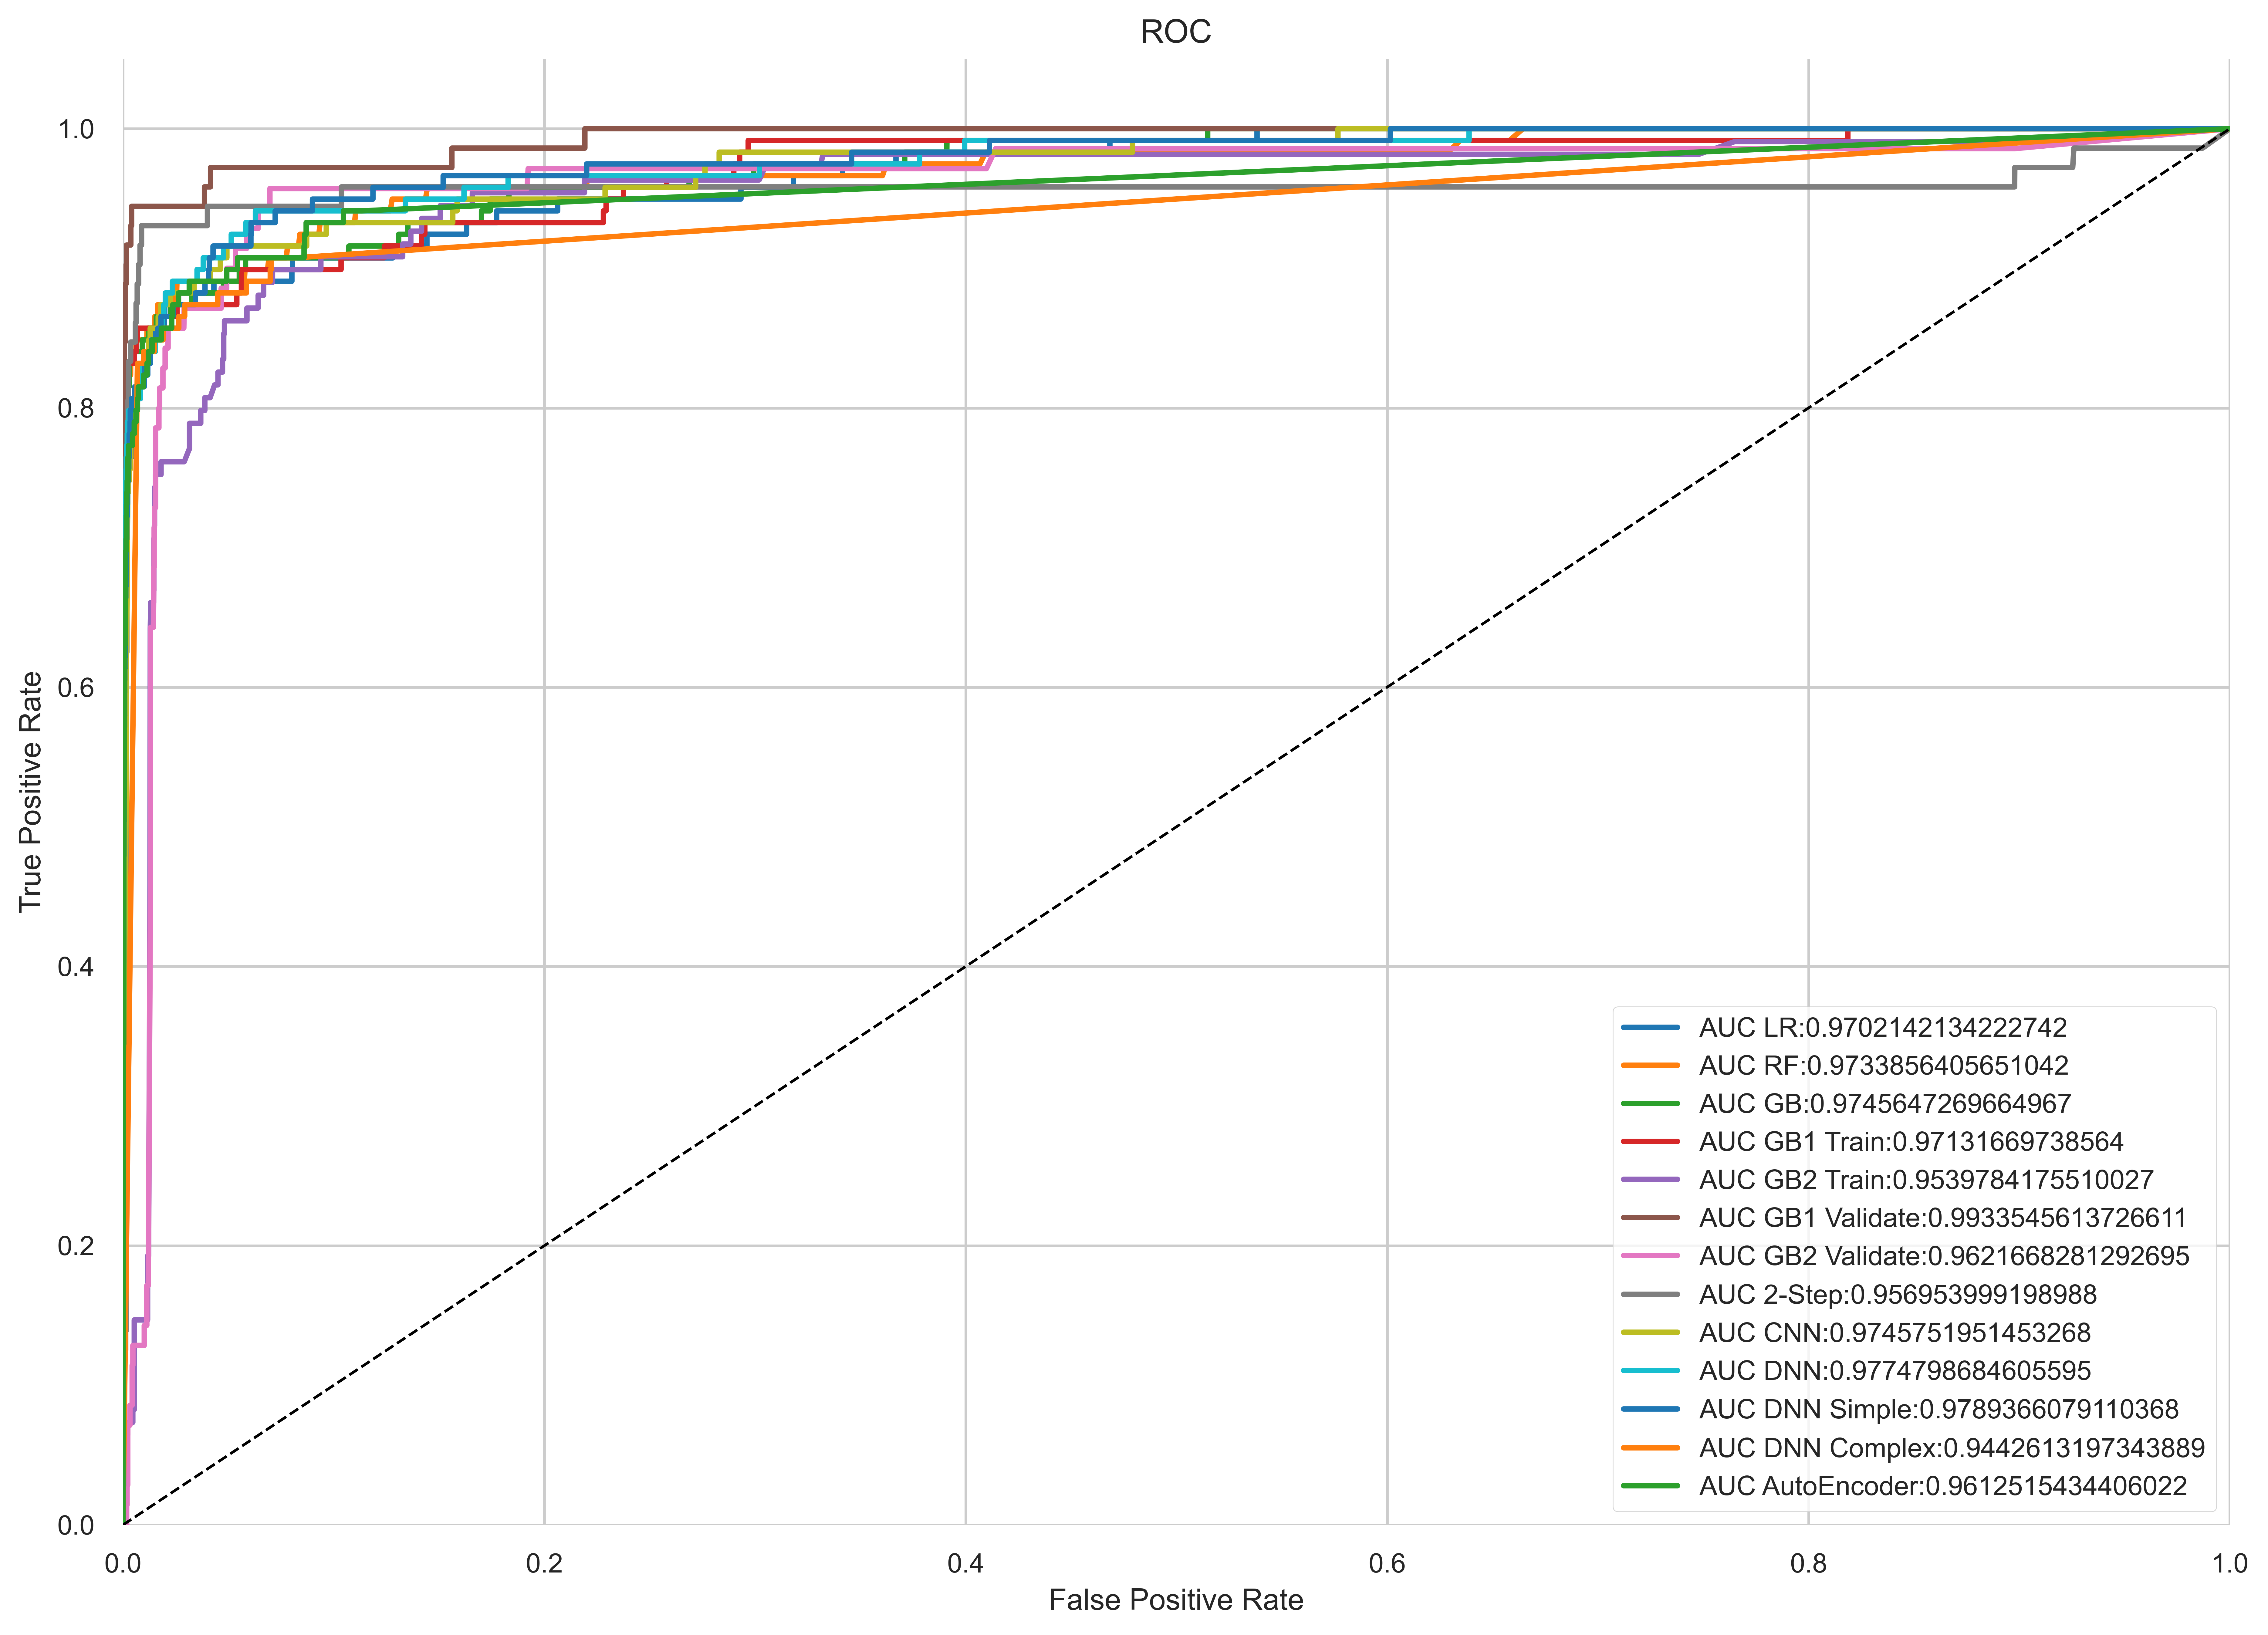

In [54]:
plt.figure(figsize=(14,10),dpi=640)

for i in range(0,len(roc)):
    #print('roc[0]', roc[0])
    #print('roc[i]', roc[i])
    auc1 = auc(roc[i][1],roc[i][2])
    plt.plot(roc[i][1],roc[i][2], label="AUC {0}:{1}".format(roc[i][0], auc1), linewidth=2)
    
plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()